In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse

import hylife.utilitis_FEEC.bsplines as bsp
import hylife.utilitis_FEEC.Bspline  as bspline 

#import hylife.utilitis_FEEC.projectors_global    as proj_global
import hylife.utilitis_FEEC.projectors_local     as proj_local

import hylife.utilitis_FEEC.evaluation           as eva
import hylife.utilitis_FEEC.derivatives          as der

import hylife.utilitis_FEEC.mass_matrices        as mass
import hylife.utilitis_FEEC.projectors_local_mhd as proj_mhd

# 3D

In [2]:
Nel       = [8, 9, 10]              # mesh generation on logical domain
bc        = [False, False, False]     # boundary conditions (True: periodic, False: else)
p         = [3, 2, 3]                 # spline degrees  


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
NbaseD    = [NbaseN - (1 - bc) for NbaseN, bc in zip(NbaseN, bc)]

Nbase_old = [Nel + p for Nel, p, bc in zip(Nel, p, bc)]

xplot     = np.linspace(0., 1., 500), np.array([0.3]), np.array([0.3])

N         = [bspline.Bspline(T, p)     for T, p in zip(T, p)]
D         = [bspline.Bspline(t, p - 1) for t, p in zip(t, p)]

In [3]:
M3_ini = mass.mass_V3_3d(T, p, bc, None, 1, [2., 3., 4.])

hello 1


In [4]:
import hylife.utilitis_FEEC.mappings as maps

geometry = maps.mappings(['slab', 2., 3., 4.])

M3_ext = mass.mass_V3_3d(T, p, bc, geometry.g_sqrt)

hello 2


In [5]:
np.allclose(M3_ini.toarray(), M3_ext.toarray())

True

In [3]:
mhd = proj_mhd.projectors_local_mhd(T, p, bc)
proj_loc = proj_local.projectors_local_3d(T, p, bc)

In [6]:
test_fun = lambda xi1, xi2, xi3 : (1 - xi1) * (1 - xi2) * (1 - xi3) * xi1 * xi2 * xi3 * N[0](xi1, 10) * N[1](xi2, 10) * N[2](xi3, 10)

In [7]:
test = mhd.projection_K(1, [1., 1., 1.])

In [8]:
proj_loc = proj_local.projectors_local_3d(T, p, bc)

In [9]:
coeff = proj_loc.PI_0(test_fun)

In [10]:
coeff2 = test[:, 2730].toarray().flatten()

In [11]:
np.allclose(coeff.flatten(), coeff2)

True

In [12]:
test

<4096x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 512000 stored elements in Compressed Sparse Row format>

In [13]:
test = mhd.projection_Q(1, [1., 1., 1.])

In [14]:
test_fun = lambda xi1, xi2, xi3 : (1 - xi1) * (1 - xi2) * (1 - xi3) * xi1 * xi2 * xi3 * D[0](xi1, 8)/delta[0] * N[1](xi2, 8) * N[2](xi3, 8)

In [15]:
coeff = proj_loc.PI_2([test_fun, test_fun, test_fun])[0].flatten()

In [16]:
coeff2 = test[:NbaseN[0]*NbaseD[1]*NbaseD[2], 2184].toarray().flatten()

In [17]:
np.allclose(coeff, coeff2)

True

In [17]:
test = mhd.projection_T(1, [1., 1., 1.])

In [11]:
test_fun = lambda xi1, xi2, xi3 :  (1 - xi1) * (1 - xi2) * (1 - xi3) * xi1 * xi2 * xi3 * N[0](xi1, 8) * N[1](xi2, 8) * D[2](xi3, 8)/delta[2]

In [12]:
coeff = proj_loc.PI_1([test_fun, test_fun, test_fun])[1].flatten()

In [13]:
coeff2 = test[NbaseD[0]*NbaseN[1]*NbaseN[2]:NbaseD[0]*NbaseN[1]*NbaseN[2]+NbaseN[0]*NbaseD[1]*NbaseN[2], 2*4096 + 2184].toarray().flatten()

In [16]:
np.allclose(coeff, -coeff2)

True

In [5]:
test = mhd.projection_W(1, [1., 1., 1.])

In [8]:
test_fun = lambda xi1, xi2, xi3 :  (1 - xi1) * (1 - xi2) * (1 - xi3) * xi1 * xi2 * xi3 * D[0](xi1, 8)/delta[0] * N[1](xi2, 8) * N[2](xi3, 8)

In [12]:
coeff = proj_loc.PI_1([test_fun, test_fun, test_fun])[0].flatten()

In [13]:
coeff2 = test[:NbaseD[0]*NbaseN[1]*NbaseN[2], 2184].toarray().flatten()

In [14]:
np.allclose(coeff, coeff2)

True

In [4]:
test = mhd.projection_P(1, [1., 1., 1.])

In [5]:
test

<19494x18468 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Column format>

In [ ]:
np.allclose(test.toarray(), test2.toarray())

In [6]:
test_fun = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)

In [9]:
#coeff_ext = proj_loc.PI_0(test_fun)
coeff = proj_loc.PI_0(None, 1, 1, [1., 1., 1.])

In [10]:
np.allclose(coeff_ext, coeff)

True

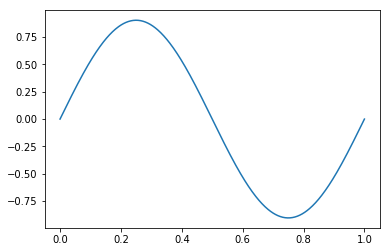

In [11]:
res   = eva.FEM_field_V0_3d(coeff_ext, xplot, T, p, bc)
plt.plot(xplot[0], res[:, 0, 0])

In [8]:
test_fun1 = lambda x, y, z : np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi
test_fun2 = lambda x, y, z : np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi
test_fun3 = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi

In [9]:
coeff_ext = proj_loc.PI_1_ext([test_fun1, test_fun2, test_fun3])
coeff = proj_loc.PI_1_ext([None, None, None])

In [10]:
print(np.allclose(coeff_ext[0], coeff[0]))
print(np.allclose(coeff_ext[1], coeff[1]))
print(np.allclose(coeff_ext[2], coeff[2]))

True
True
True


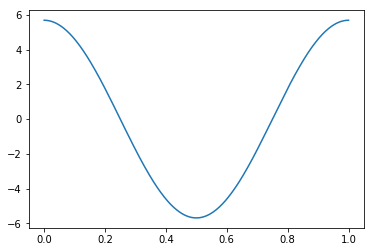

In [11]:
res   = eva.FEM_field_V1_3d(coeff, xplot, T, p, bc)
plt.plot(xplot[0], res[0][:, 0, 0])

In [12]:
test_fun1 = lambda x, y, z : np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.cos(2*np.pi*z)*(2*np.pi)**2
test_fun2 = lambda x, y, z : np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*(2*np.pi)**2
test_fun3 = lambda x, y, z : np.cos(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*(2*np.pi)**2

In [13]:
coeff_ext = proj_loc.PI_2_ext([test_fun1, test_fun2, test_fun3])
coeff = proj_loc.PI_2_ext([None, None, None])

In [14]:
print(np.allclose(coeff_ext[0], coeff[0]))
print(np.allclose(coeff_ext[1], coeff[1]))
print(np.allclose(coeff_ext[2], coeff[2]))

True
True
True


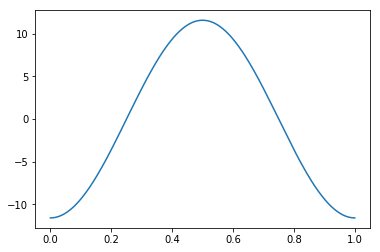

In [15]:
res   = eva.FEM_field_V2_3d(coeff, xplot, T, p, bc)
plt.plot(xplot[0], res[2][:, 0, 0])

In [16]:
test_fun = lambda x, y, z : np.cos(2*np.pi*x)*np.cos(2*np.pi*y)*np.cos(2*np.pi*z)*(2*np.pi)**3

In [18]:
coeff_ext = proj_loc.PI_3_ext(test_fun)
coeff = proj_loc.PI_3_ext(None)

In [19]:
np.allclose(coeff_ext, coeff)

True

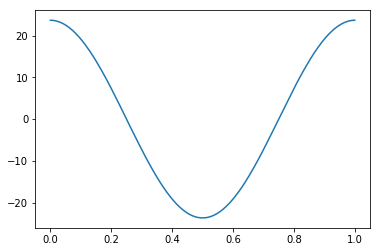

In [20]:
res   = eva.FEM_field_V3_3d(coeff_ext, xplot, T, p, bc)
plt.plot(xplot[0], res[:, 0, 0])

In [21]:
deriv = der.discrete_derivatives(T, p, bc)

GRAD = deriv.GRAD_3d()
CURL = deriv.CURL_3d()
DIV  = deriv.DIV_3d()

In [22]:
# commutativity V0, V1?
test_fun  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)

test_fun1 = lambda x, y, z : np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi
test_fun2 = lambda x, y, z : np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi
test_fun3 = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi

lhs = GRAD.dot(proj_loc.PI_0_ext(test_fun).flatten())

rhs = proj_loc.PI_1_ext([test_fun1, test_fun2, test_fun3])
rhs = np.concatenate((rhs[0].flatten(), rhs[1].flatten(), rhs[2].flatten()))

print(np.abs(rhs - lhs).max())

4.2119085996716876e-14


In [23]:
# commutativity V1, V2?
test_fun1  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)
test_fun2  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)
test_fun3  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)

test_fun1d = lambda x, y, z : np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi - np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi
test_fun2d = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi - np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi
test_fun3d = lambda x, y, z : np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi - np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi

lhs = proj_loc.PI_1_ext([test_fun1, test_fun2, test_fun3])
lhs = CURL.dot(np.concatenate((lhs[0].flatten(), lhs[1].flatten(), lhs[2].flatten())))

rhs = proj_loc.PI_2_ext([test_fun1d, test_fun2d, test_fun3d])
rhs = np.concatenate((rhs[0].flatten(), rhs[1].flatten(), rhs[2].flatten()))

print(np.abs(rhs - lhs).max())

1.5439038936193583e-15


In [24]:
# commutativity V2, V3?
test_fun1  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)
test_fun2  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)
test_fun3  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)

test_fun   = lambda x, y, z : np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi + np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi + np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi

lhs = proj_loc.PI_2_ext([test_fun1, test_fun2, test_fun3])
lhs = DIV.dot(np.concatenate((lhs[0].flatten(), lhs[1].flatten(), lhs[2].flatten())))

rhs = proj_loc.PI_3_ext(test_fun).flatten()

print(np.abs(rhs - lhs).max())

5.328853677766254e-17


In [19]:
grad = der.GRAD_1d(T[0], p[0], bc[0])

In [20]:
grad

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.]])

In [3]:
test = proj_new.projectors_3d(T, p, bc)
test_old = proj.projectors_3d(p, Nbase_old, T, bc)

In [4]:
test.assemble_V0()
test.assemble_V1()
test.assemble_V2()
test.assemble_V3()

test_old.assemble_V0()
test_old.assemble_V1()
test_old.assemble_V2()
test_old.assemble_V3()

In [5]:
a0       = lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1)*np.sin(2*np.pi*xi2)*np.sin(2*np.pi*xi3)

vec0     = test.PI_0(a0)
vec0_old = test_old.PI_0(a0)

In [6]:
np.allclose(vec0, vec0_old.reshape(NbaseN[0], NbaseN[1], NbaseN[2]))

True

In [7]:
a1       = [lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1)*np.sin(2*np.pi*xi2)*np.sin(2*np.pi*xi3), lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1)*np.cos(2*np.pi*xi2)*np.sin(2*np.pi*xi3), lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1)*np.sin(2*np.pi*xi2)*np.cos(2*np.pi*xi3)]
vec1     = test.PI_1(a1)
vec1_old = test_old.PI_1(a1)

In [8]:
print(np.allclose(vec1[0], vec1_old[0].reshape(NbaseD[0], NbaseN[1], NbaseN[2])))
print(np.allclose(vec1[1], vec1_old[1].reshape(NbaseN[0], NbaseD[1], NbaseN[2])))
print(np.allclose(vec1[2], vec1_old[2].reshape(NbaseN[0], NbaseN[1], NbaseD[2])))

True
True
True


In [9]:
a2       = [lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1)*np.cos(2*np.pi*xi2)*np.cos(2*np.pi*xi3), lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1)*np.sin(2*np.pi*xi2)*np.cos(2*np.pi*xi3), lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1)*np.cos(2*np.pi*xi2)*np.sin(2*np.pi*xi3)]
vec2     = test.PI_2(a2)
vec2_old = test_old.PI_2(a2)

In [10]:
print(np.allclose(vec2[0], vec2_old[0].reshape(NbaseN[0], NbaseD[1], NbaseD[2])))
print(np.allclose(vec2[1], vec2_old[1].reshape(NbaseD[0], NbaseN[1], NbaseD[2])))
print(np.allclose(vec2[2], vec2_old[2].reshape(NbaseD[0], NbaseD[1], NbaseN[2])))

True
True
True


In [11]:
a3       = lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1)*np.cos(2*np.pi*xi2)*np.cos(2*np.pi*xi3)
vec3     = test.PI_3(a3)
vec3_old = test_old.PI_3(a3)

In [12]:
np.allclose(vec3, vec3_old.reshape(NbaseD[0], NbaseD[1], NbaseD[2]))

True

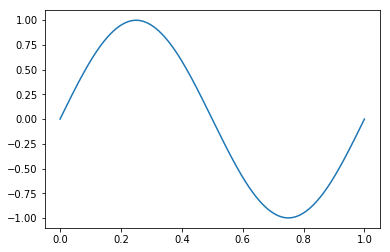

In [13]:
xplot = np.linspace(0., 1., 500)
res   = eva.FEM_field_V0_3d(vec0, [xplot, np.array([0.25]), np.array([0.25])], T, p, bc)
plt.plot(xplot, res[:, 0, 0])

# 1D

In [9]:
Nel       = 8                           # number of elements   
bc        = False                         # boundary conditions (True: periodic, False: else)
p         = 3                            # spline degres  

el_b      = np.linspace(0., 1., Nel + 1) # element boundaries
delta     = 1/Nel                        # element size
T         = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)
t         = T[1:-1]                      # reduced knot vector (for D function)
NbaseN    = Nel + p - bc*p               # number of basis functions (N functions)
NbaseD    = NbaseN - (1 - bc)            # number of basis functions (D functions)

N = bspline.Bspline(T, p)
D = bspline.Bspline(t, p - 1)

xplot = np.linspace(0., 1., 200)

In [10]:
# global and local projectors
#proj_glob = proj_new.projectors_1d(T, p, bc)
proj_loc  = proj_local.projectors_local_1d(T, p, bc)

# assemble interpolation and histopolation matrix for global projector
#proj_glob.assemble_V0()
#proj_glob.assemble_V1()

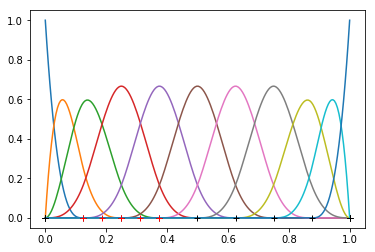

In [12]:
for i in range(N.N):
    plt.plot(xplot, N(xplot, i))
    
plt.plot(T, np.zeros(len(T)), 'k+')

plt.plot(proj_loc.x_int[3], np.zeros(5), 'r+')

In [8]:
T

array([0.   , 0.   , 0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 ,
       0.875, 1.   , 1.   , 1.   ])

In [6]:
proj_loc.x_int

array([[0.    , 0.0625, 0.125 ],
       [0.    , 0.0625, 0.125 ],
       [0.125 , 0.1875, 0.25  ],
       [0.25  , 0.3125, 0.375 ],
       [0.375 , 0.4375, 0.5   ],
       [0.5   , 0.5625, 0.625 ],
       [0.625 , 0.6875, 0.75  ],
       [0.75  , 0.8125, 0.875 ],
       [0.875 , 0.9375, 1.    ],
       [0.875 , 0.9375, 1.    ]])

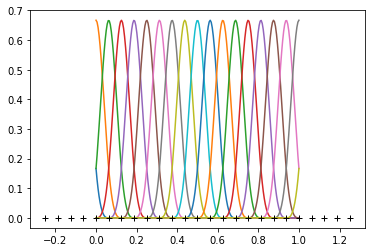

In [39]:
for i in range(D.N):
    plt.plot(xplot, D(xplot, i))
    
plt.plot(T, np.zeros(len(T)), 'k+')

In [342]:
def fun(x):
    return (N(x, 0) + 1*N(x, 10))*np.sin(2*np.pi*x)
    #return (D(x, 0) + 1*D(x, 10))*np.sin(2*np.pi*x)

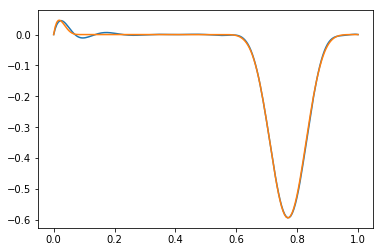

In [343]:
coeff = proj_glob.PI_0(fun) 
res   = eva.FEM_field_V0_1d(coeff, xplot, T, p, bc)

'''
for i in range(D.N):
    plt.plot(xplot, D(xplot, i))
    
plt.plot(T, np.zeros(len(T)), 'k+')
'''

plt.plot(xplot, res)
plt.plot(xplot, fun(xplot))

In [344]:
coeff

array([ 0.        ,  0.09925859, -0.06557152,  0.0349537 , -0.01285536,
        0.00530355, -0.00373894,  0.00639581, -0.0163412 ,  0.04975009,
       -1.04551338,  0.12000095, -0.02669372,  0.00492743, -0.        ])

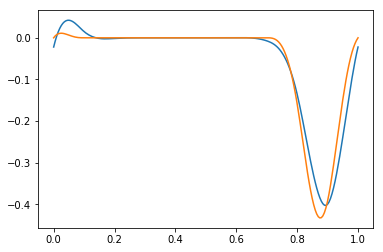

In [102]:
coeff = proj_loc.PI_0(fun) 
res   = eva.FEM_field_V0_1d(coeff, xplot, T, p, bc)

'''
for i in range(D.N):
    plt.plot(xplot, D(xplot, i))
    
plt.plot(T, np.zeros(len(T)), 'k+')
'''

plt.plot(xplot, res)
plt.plot(xplot, fun(xplot))

In [8]:
# global assembly of projection matrix PI_0(D)
basis = bsp.collocation_matrix(t, p - 1, proj_loc.x_int.flatten(), bc)
tau_glob = np.zeros((NbaseD, NbaseN))

for i in range(NbaseD):
    
    if bc == False:
        fun = lambda x : D(x, i)
    else:
        if i < p - 1:
            fun = lambda x : D(x, i) + D(x, NbaseD + i)
        else:
            fun = lambda x : D(x, i) 
            
    tau_glob[i, :] = proj_loc.PI_0(fun)

In [9]:
# local assembly of projection matrix PI_0(D)

# non-vanishing coefficients (# basis functions (bf) of sntp,  maximum # of non-vanishing coefficients for each bf)
tau_loc = np.zeros((NbaseD, proj_loc.n_int_nvcof_D))

# evaluation of sntp at interpolation points
basis = bsp.collocation_matrix(t, p - 1, proj_loc.x_int.flatten(), bc).reshape(NbaseN, proj_loc.n_int, NbaseD)

# loop over coefficients
for i in range(NbaseN):
    
    # loop over interpolation points
    for j in range(proj_loc.n_int):
        
        # loop over non-vanishing bf
        for kl in range(proj_loc.n_int_locbf_D):
            k      = proj_loc.int_global_D[i, kl]     # global index of bf 
            c_loc  = proj_loc.int_loccof_D[i, kl]     # local index of non-vanishing coefficients for this bf
            
            tau_loc[k, c_loc] += proj_loc.coeff_i[i, j] * basis[i, j, k]
            
            
# global indices in final matrix
indices = np.indices((NbaseD, proj_loc.n_int_nvcof_D))

# row indices
row = indices[0]

# column indices
col = (indices[1] + proj_loc.int_shift_D[:, None])%NbaseN

# build matrix
tau_loc = sparse.csr_matrix((tau_loc.flatten(), (row.flatten(), col.flatten())), shape=(NbaseD, NbaseN))

In [10]:
np.allclose(tau_glob, tau_loc.toarray())

True

In [11]:
# global assembly of projection matrix PI_0(N)
basis = bsp.collocation_matrix(T, p, proj_loc.x_int.flatten(), bc)
tau_glob = np.zeros((NbaseN, NbaseN))

for i in range(NbaseN):
    
    if bc == False:
        fun = lambda x : N(x, i) * np.cos(2*np.pi*x)
    else:
        if i < p:
            fun = lambda x : (N(x, i) + N(x, NbaseN + i)) * np.cos(2*np.pi*x)
        else:
            fun = lambda x : N(x, i) * np.cos(2*np.pi*x)
            
    tau_glob[i, :] = proj_loc.PI_0(fun)

In [12]:
# local assembly of projection matrix PI_0(N)

# non-vanishing coefficients (# basis functions (bf) of sntp,  maximum # of non-vanishing coefficients for each bf)
tau_loc = np.zeros((NbaseN, proj_loc.n_int_nvcof_N))

# evaluation of sntp at interpolation points
basis = bsp.collocation_matrix(T, p, proj_loc.x_int.flatten(), bc).reshape(NbaseN, proj_loc.n_int, NbaseN)


# loop over coefficients
for i in range(NbaseN):
    
    # loop over interpolation points
    for j in range(proj_loc.n_int):
        
        # loop over non-vanishing bf
        for kl in range(proj_loc.n_int_locbf_N):
            k      = proj_loc.int_global_N[i, kl]    # global index of bf 
            c_loc  = proj_loc.int_loccof_N[i, kl]    # local index of non-vanishing coefficients for this bf
            
            tau_loc[k, c_loc] += proj_loc.coeff_i[i, j] * basis[i, j, k] * np.cos(2*np.pi*proj_loc.x_int[i, j])
            

# global indices in final matrix
indices = np.indices((NbaseN, proj_loc.n_int_nvcof_N))

# row indices
row = indices[0]

# column indices
col = (indices[1] + proj_loc.int_shift_N[:, None])%NbaseN

# build matrix
tau_loc = sparse.csr_matrix((tau_loc.flatten(), (row.flatten(), col.flatten())), shape=(NbaseN, NbaseN))

In [13]:
np.allclose(tau_loc.toarray(), tau_glob)

True

In [14]:
# global assembly of projection matrix PI_1(D)
tau_glob = np.zeros((NbaseD, NbaseD))

for i in range(NbaseD):
    
    if bc == False:
        fun = lambda x : D(x, i) * np.cos(2*np.pi*x)
    else:
        if i < p - 1:
            fun = lambda x : (D(x, i) + D(x, NbaseD + i)) * np.cos(2*np.pi*x)
        else:
            fun = lambda x : D(x, i) * np.cos(2*np.pi*x)
            
    tau_glob[i, :] = proj_loc.PI_1(fun)

In [15]:
# local assembly of projection matrix PI_1(D)

# non-vanishing coefficients (# basis functions (bf) of sntp,  maximum # of non-vanishing coefficients for each bf)
tau_loc = np.zeros((NbaseD, proj_loc.n_his_nvcof_D))

# evaluation of sntp at quadrature points
basis = bsp.collocation_matrix(t, p - 1, proj_loc.pts.flatten(), bc).reshape(NbaseD, proj_loc.n_his, proj_loc.n_quad, NbaseD)


# loop over coefficients
for i in range(NbaseD):
    
    # loop over histopolation intervals
    for j in range(proj_loc.n_his):
        
        # loop over non-vanishing bf
        for kl in range(proj_loc.n_his_locbf_D):
            k      = proj_loc.his_global_D[i, kl]    # global index of bf 
            c_loc  = proj_loc.his_loccof_D[i, kl]    # local index of non-vanishing coefficients for this bf
            
            f_int = 0.
            
            for q in range(proj_loc.n_quad):
                f_int += proj_loc.wts[i, j, q] * basis[i, j, q, k] * np.cos(2*np.pi*proj_loc.pts[i, j, q])
            
            tau_loc[k, c_loc] += proj_loc.coeff_h[i, j] * f_int
            
            
# global indices in final matrix
indices = np.indices((NbaseD, proj_loc.n_his_nvcof_D))

# row indices
row = indices[0]

# column indices
col = (indices[1] + proj_loc.his_shift_D[:, None])%NbaseD

# build matrix
tau_loc = sparse.csr_matrix((tau_loc.flatten(), (row.flatten(), col.flatten())), shape=(NbaseD, NbaseD))

In [16]:
np.allclose(tau_loc.toarray(), tau_glob)

True

In [17]:
# global assembly of projection matrix PI_1(N)
tau_glob = np.zeros((NbaseN, NbaseD))

for i in range(NbaseN):
    
    if bc == False:
        fun = lambda x : N(x, i) * np.cos(2*np.pi*x)
    else: 
        if i < p:
            fun = lambda x : (N(x, i) + N(x, NbaseN + i)) * np.cos(2*np.pi*x)
        else:
            fun = lambda x : N(x, i) * np.cos(2*np.pi*x)
            
    tau_glob[i, :] = proj_loc.PI_1(fun)

In [18]:
# local assembly of projection matrix PI_1(N)

# non-vanishing coefficients (# basis functions (bf) of sntp,  maximum # of non-vanishing coefficients for each bf)
tau_loc = np.zeros((NbaseN, proj_loc.n_his_nvcof_N))

# evaluation of sntp at quadrature points
basis = bsp.collocation_matrix(T, p, proj_loc.pts.flatten(), bc).reshape(NbaseD, proj_loc.n_his, proj_loc.n_quad, NbaseN)


# loop over coefficients
for i in range(NbaseD):
    
    # loop over histopolation intervals
    for j in range(proj_loc.n_his):
        
        # loop over non-vanishing bf
        for kl in range(proj_loc.n_his_locbf_N):
            k      = proj_loc.his_global_N[i, kl]    # global index of bf 
            c_loc  = proj_loc.his_loccof_N[i, kl]    # local index of non-vanishing coefficients for this bf
            
            f_int = 0.
            
            for q in range(proj_loc.n_quad):
                f_int += proj_loc.wts[i, j, q] * basis[i, j, q, k] * np.cos(2*np.pi*proj_loc.pts[i, j, q])
            
            tau_loc[k, c_loc] += proj_loc.coeff_h[i, j] * f_int
            
            
# global indices in final matrix
indices = np.indices((NbaseN, proj_loc.n_his_nvcof_N))

# row indices
row = indices[0]

# column indices
col = (indices[1] + proj_loc.his_shift_N[:, None])%NbaseD

# build matrix
tau_loc = sparse.csr_matrix((tau_loc.flatten(), (row.flatten(), col.flatten())), shape=(NbaseN, NbaseD))

In [19]:
np.allclose(tau_loc.toarray(), tau_glob)

True

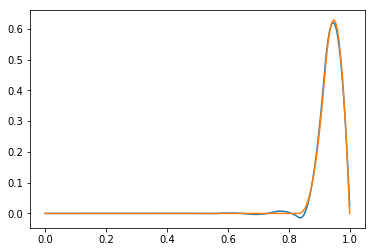

In [20]:
# L2-projection
rhs = mass.inner_prod_V0_1d(T, p, bc, lambda x : 1., fun)
M0  = mass.mass_1d_NN(T, p, bc)
coeff = np.linalg.solve(M0.toarray(), rhs)

res   = eva.FEM_field_V0_1d(coeff, xplot, T, p, bc)

'''
for i in range(D.N):
    plt.plot(xplot, D(xplot, i))
    
plt.plot(T, np.zeros(len(T)), 'k+')
'''

plt.plot(xplot, res)
plt.plot(xplot, fun(xplot))

In [21]:
coeff

array([ 6.38049938e-06, -1.38304559e-05,  2.02471985e-05, -4.22887196e-05,
        9.61920051e-05, -2.22533346e-04,  5.16454158e-04, -1.19931071e-03,
        2.78577898e-03, -6.48102155e-03,  1.53107718e-02, -4.15635876e-02,
        9.40554975e-01,  2.48057967e-02])

In [163]:
values = np.zeros((7, 7))

i = 4
x = np.array([T[p + i], (T[p + i] + T[p + 1 + i])/2, T[p + 1 + i], (T[p + 1 + i] + T[p + 2 + i])/2, T[p + 2 + i], (T[p + 2 + i] + T[p + 3 + i])/2, T[p + 3 + i]])

for i in range(7):
    for j in range(7):
        
        values[i, j] = N(x[j], i + 4) 
        
45/2*np.linalg.solve(values, np.array([0., 0., 0., 1., 0., 0., 0.]))

array([ -1.  ,  16.  , -73.75, 140.  , -73.75,  16.  ,  -1.  ])

In [177]:
int(3/2 + 1/2)

2

In [48]:
test_fun = lambda x : np.sin(2*np.pi*x)
test_fun_d = lambda x : np.cos(2*np.pi*x)*2*np.pi

In [49]:
coeff = proj_loc.PI_0(test_fun)

In [50]:
coeff

array([-0.57372817, -0.20146654,  0.20146654,  0.57372817,  0.85864488,
        1.0128407 ,  1.0128407 ,  0.85864488,  0.57372817,  0.20146654,
       -0.20146654, -0.57372817, -0.85864488, -1.0128407 , -1.0128407 ,
       -0.85864488])

In [51]:
mass.L2_error_V0_1d(coeff, T, p, bc, test_fun)

5.984051317907733e-06

In [52]:
res = eva.FEM_field_V0_1d(coeff, xplot, T, p, bc)

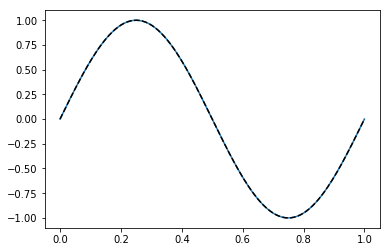

In [53]:
plt.plot(xplot, res)
plt.plot(xplot, test_fun(xplot), 'k--')

In [54]:
coeff = proj_loc.PI_1(test_fun)

In [55]:
res = eva.FEM_field_V1_1d(coeff, xplot, T, p, bc)

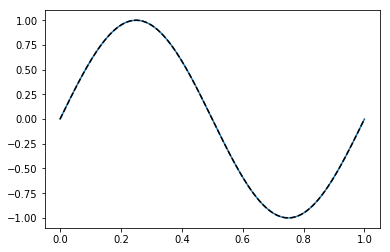

In [56]:
plt.plot(xplot, res)
plt.plot(xplot, test_fun(xplot), 'k--')

In [57]:
# commutativity ?
grad  = der.GRAD_1d(T, p, bc)
coeff = proj_loc.PI_0(test_fun)

lhs = grad.dot(coeff)

rhs = proj_loc.PI_1(test_fun_d)

In [58]:
lhs

array([ 3.72261627e-01,  4.02933082e-01,  3.72261627e-01,  2.84916715e-01,
        1.54195815e-01,  4.44089210e-16, -1.54195815e-01, -2.84916715e-01,
       -3.72261627e-01, -4.02933082e-01, -3.72261627e-01, -2.84916715e-01,
       -1.54195815e-01,  0.00000000e+00,  1.54195815e-01,  2.84916715e-01])

In [59]:
rhs

array([ 3.72261627e-01,  4.02933082e-01,  3.72261627e-01,  2.84916715e-01,
        1.54195815e-01,  2.60208521e-18, -1.54195815e-01, -2.84916715e-01,
       -3.72261627e-01, -4.02933082e-01, -3.72261627e-01, -2.84916715e-01,
       -1.54195815e-01, -5.11743425e-17,  1.54195815e-01,  2.84916715e-01])

In [31]:
high = np.repeat(T, 4)[9:-9]

In [32]:
high

array([-0.1, -0.1, -0.1,  0. ,  0. ,  0. ,  0. ,  0.1,  0.1,  0.1,  0.1,
        0.2,  0.2,  0.2,  0.2,  0.3,  0.3,  0.3,  0.3,  0.4,  0.4,  0.4,
        0.4,  0.5,  0.5,  0.5,  0.5,  0.6,  0.6,  0.6,  0.6,  0.7,  0.7,
        0.7,  0.7,  0.8,  0.8,  0.8,  0.8,  0.9,  0.9,  0.9,  0.9,  1. ,
        1. ,  1. ,  1. ,  1.1,  1.1,  1.1])

In [39]:
i = 5
for j in range(2*(2*p - 1) + 1):
    x = (high[i + 1 + int(j/2)] + high[i + 1 + int((j + 1)/2)])/2
    print(x)

0.0
0.05
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.15000000000000002
0.2


In [37]:
el_b

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [30]:
test = np.zeros((5, 5))

In [33]:
test[:, :] = np.array([[1.]])

In [34]:
test

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [6]:
n_loc_N = 5
np.arange(n_loc_N - 1, -1, -1)

array([4, 3, 2, 1, 0])

In [19]:
h = np.array([0, 1, 2, 3])

In [23]:
np.isin(np.array([1, 2, 3, 4]), h)

array([ True,  True,  True, False])

In [29]:
np.any(h==4)

False

In [27]:
test

<12x13 sparse matrix of type '<class 'numpy.float64'>'
	with 46 stored elements in Compressed Sparse Row format>

In [26]:
test.eliminate_zeros()

In [22]:
test = [0, 0, 0]

In [24]:
test[0] = 1

In [25]:
test

[1, 0, 0]

In [26]:
test[0] = None

In [27]:
test

[None, 0, 0]

In [28]:
test[0] = np.zeros(5)

In [29]:
test

[array([0., 0., 0., 0., 0.]), 0, 0]